<a href="https://colab.research.google.com/github/myonei/TCC_UAM/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise epidemiológica e previsão de casos de COVID-19 utilizando Machine Learning**

In [84]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00


In [85]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Montando o drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Leitura das bases

df = pd.read_csv("drive/MyDrive/TCC - UAM/estudo/datasets/brazil_covid19.csv")

mapa_brasil = gpd.read_file('drive/MyDrive/TCC - UAM/estudo/BR_UF_2022/BR_UF_2022.shp')

# Análise Exploratória da Base

In [4]:
df.head()

,date,region,state,cases,deaths
0,2020-02-25,Centro-Oeste,DF,0.0,0
1,2020-02-25,Centro-Oeste,GO,0.0,0
2,2020-02-25,Centro-Oeste,MS,0.0,0
3,2020-02-25,Centro-Oeste,MT,0.0,0
4,2020-02-25,Nordeste,AL,0.0,0


In [5]:
# Datas mínima e máxima
df.date.min(), df.date.max()

('2020-02-25', '2021-05-23')

In [6]:
# Quantidade de observações e colunas
df.shape

(12258, 5)

In [7]:
# Porcentagem de nulos por coluna
df.isnull().mean()

date      0.0
region    0.0
state     0.0
cases     0.0
deaths    0.0
dtype: float64

In [9]:
#Tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12258 entries, 0 to 12257
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    12258 non-null  object 
 1   region  12258 non-null  object 
 2   state   12258 non-null  object 
 3   cases   12258 non-null  float64
 4   deaths  12258 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 479.0+ KB


In [10]:
# Análise descritiva
df.describe()

,cases,deaths
count,1.225800e+04,12258.000000
mean,2.085151e+05,5701.935308
std,3.281497e+05,10238.310905
min,0.000000e+00,0.000000
25%,2.184225e+04,558.250000
50%,1.065500e+05,2627.000000
75%,2.524558e+05,6534.000000
max,3.188105e+06,107614.000000


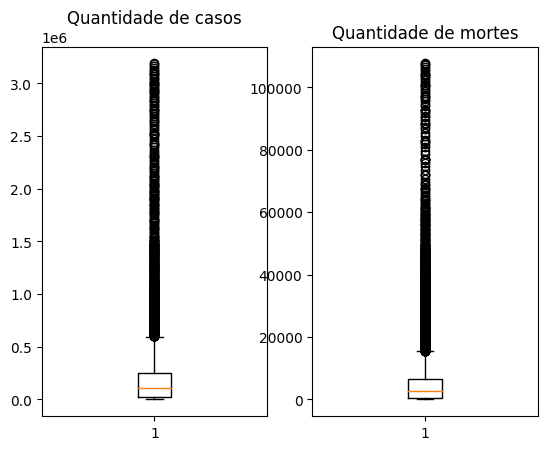

In [14]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot the boxplots
ax1.boxplot(df['cases'])
ax2.boxplot(df['deaths'])

# Set the titles
ax1.set_title('Quantidade de casos')
ax2.set_title('Quantidade de mortes')

# Show the plot
plt.show()

Do boxplot acima, nota-se que há uma grande variação de outliers, por Estado e data.

In [15]:
dfaux = df[['state', 'cases', 'deaths']].groupby(by='state').sum()

In [23]:
def print_mapa(df, valor, mapa, titulo):
    # Combine os dados com o mapa do Brasil
    mapa_aux = mapa.merge(df[['state', valor]], left_on='SIGLA_UF', right_on='state')

    # Plotar o mapa com o heatmap
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    mapa_aux.boundary.plot(ax=ax, linewidth=1)
    mapa_aux.plot(column= valor, ax=ax, legend=True, cmap='YlOrRd')

    # Adicionar as siglas dos estados no mapa
    for x, y, label in zip(mapa_aux.geometry.centroid.x,
                        mapa_aux.geometry.centroid.y,
                        mapa_aux['SIGLA_UF']):
        ax.text(x, y, label, fontsize=8, ha='center', color='black')

    plt.title(f'{titulo}')
    plt.show()

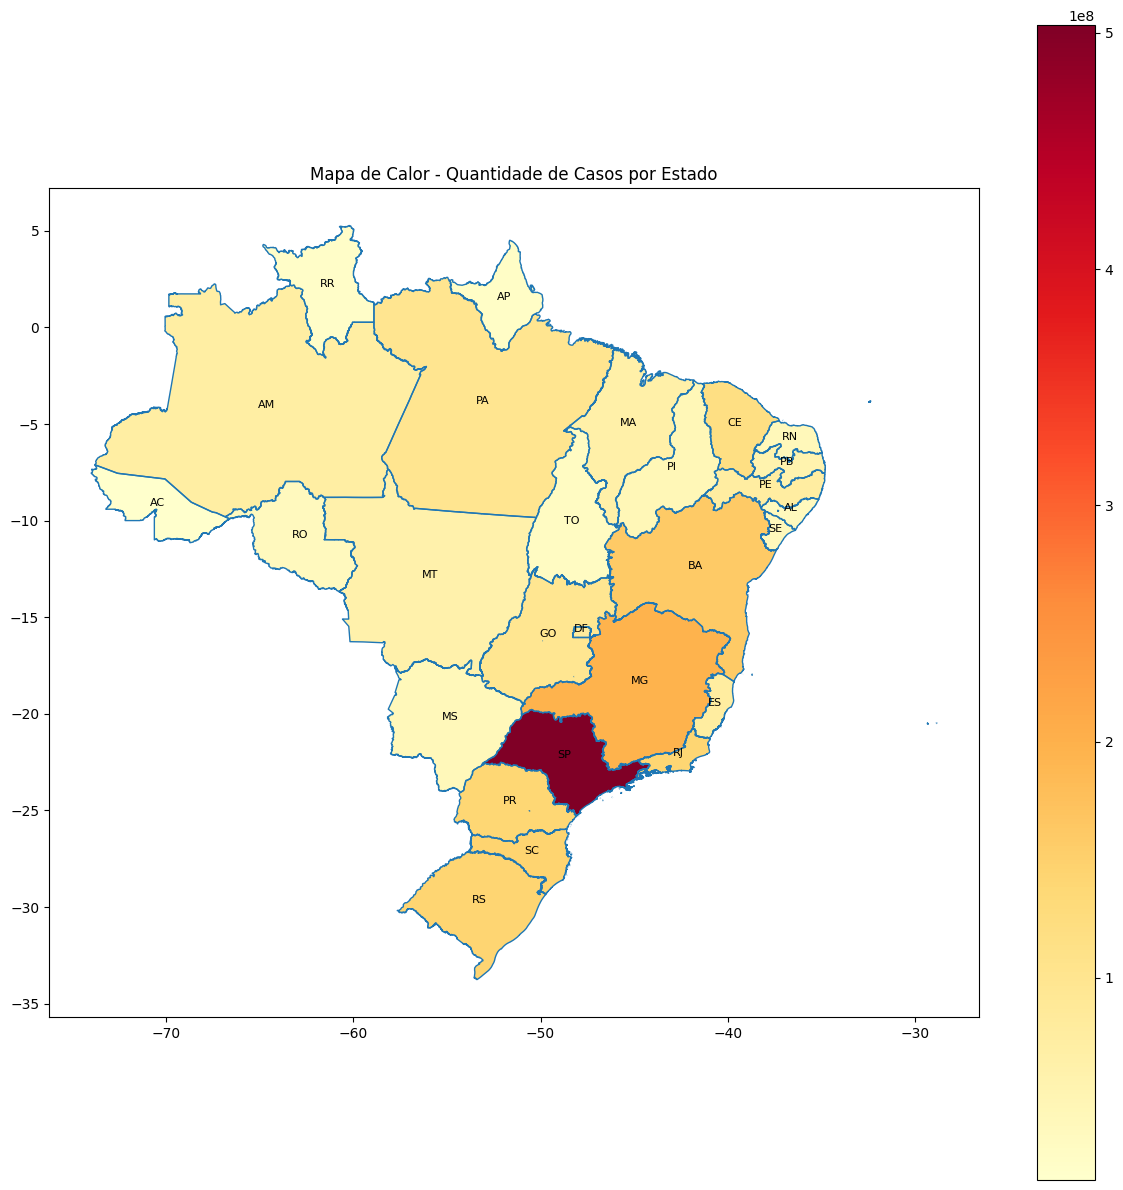

In [24]:
print_mapa(dfaux.reset_index(), 'cases', mapa_brasil, 'Mapa de Calor - Quantidade de Casos por Estado')

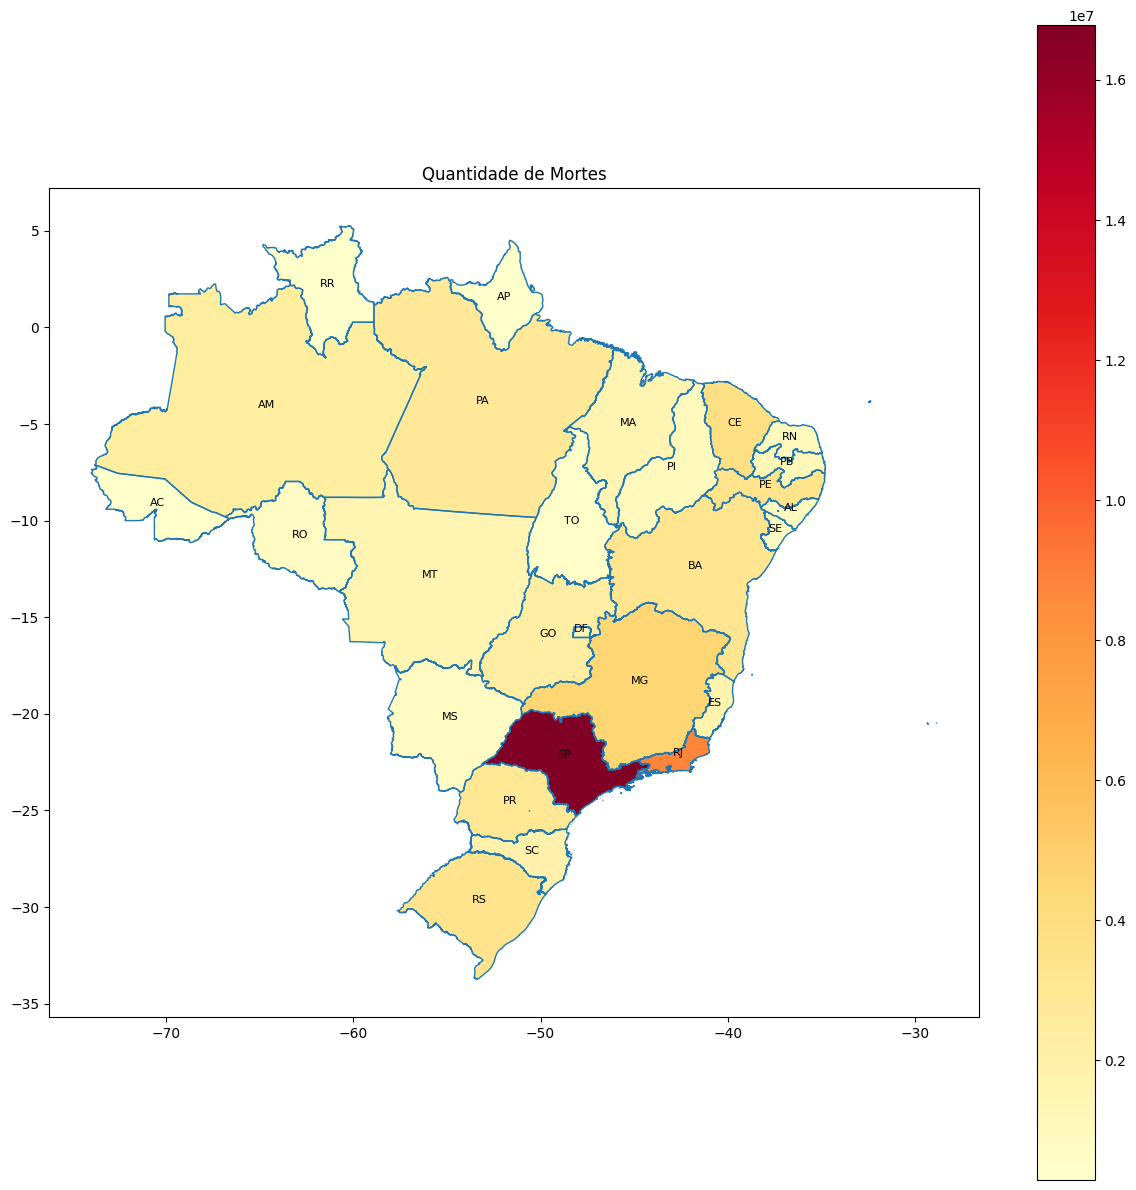

In [25]:
print_mapa(dfaux.reset_index(), 'deaths', mapa_brasil, 'Quantidade de Mortes')

Dos heatmaps acima, vemos que há uma concentração de casos no sudeste, principalmente em razão dos polos econômicos e também pela densidade populacional.

No entanto, é curioso notar que, apesar de haver uma mesma quantidade aparente de casos no Paraná e no Rio de Janeiro, a quantidade de mortes no Rio de Janeiro é maior.

Neste sentido, segue abaixo uma análise das médias de casos de COVID-19 entre os estados de Paraná (PR) e Rio de Janeiro (RJ)

# Testes de Hipótese

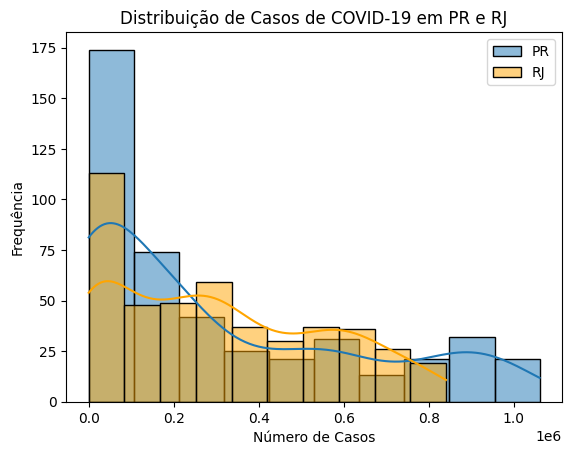

In [32]:
# Filtrar dados para MG e RJ
pr_data = df[df['state'] == 'PR']['cases']
rj_data = df[df['state'] == 'RJ']['cases']

# Verificar suposições do teste t
# Histograma para verificação de normalidade
sns.histplot(pr_data, kde=True, label='PR')
sns.histplot(rj_data, kde=True, label='RJ', color='orange')
plt.xlabel('Número de Casos')
plt.ylabel('Frequência')
plt.legend()
plt.title('Distribuição de Casos de COVID-19 em PR e RJ')
plt.show()

Do gráfico acima, verificamos que não se trata de uma distribuição normal para ambos os casos.

Vamos realizar alguns testes para verificar nossa hipótese de que não é uma distribuição normal. Para os teste seguintes, sempre considerar um nível de significância de 0.05.

## Teste de Shapiro-Wilk para normalidade

In [33]:
# Teste de Shapiro-Wilk para normalidade
normalidade_pr = stats.shapiro(pr_data)
normalidade_rj = stats.shapiro(rj_data)
print(f'Teste de Shapiro-Wilk para PR: {normalidade_pr}')
print(f'Teste de Shapiro-Wilk para RJ: {normalidade_rj}')

Teste de Shapiro-Wilk para PR: ShapiroResult(statistic=0.8436740636825562, pvalue=8.81867510021083e-21)
Teste de Shapiro-Wilk para RJ: ShapiroResult(statistic=0.9308609962463379, pvalue=1.2106950912724873e-13)


Assim, para confirmar a suposição inicial, verificamos que não se trata de uma distribuição normal, pois:

 * Os valores da estatística do teste estão significativamente abaixo de 1, sugerindo que os dados não seguem uma distribuição normal; e
 * Os valores-p são extremamente baixos (muito menores que 0.05), o que indica uma rejeição clara da hipótese nula de normalidade.


## Teste de Levene para homogeneidade das variâncias

In [34]:
# Teste de Levene para homogeneidade das variâncias
homogeneidade = stats.levene(pr_data, rj_data)
print(f'Teste de Levene: {homogeneidade}')

Teste de Levene: LeveneResult(statistic=15.926624741044868, pvalue=7.116728213819034e-05)


O valor alto do teste estatístico sugere que há uma grande diferença entre as variâncias dos grupos.
O valor-p é extremamente baixo, muito menor que 0.05.

Dado que o valor-p é muito menor que 0.05, **rejeitamos a hipótese nula** de que as variâncias dos grupos são iguais. Portanto, há evidências estatísticas significativas de que as variâncias entre os grupos são diferentes.


## Comparação de médias

In [35]:
# Teste t de Student
t_test_result = stats.ttest_ind(pr_data, rj_data, equal_var=homogeneidade.pvalue > 0.05)
print(f'Resultado do Teste t: {t_test_result}')

Resultado do Teste t: TtestResult(statistic=-0.11747767244400106, pvalue=0.9065095163479397, df=843.0980947383854)


Dado que o valor-p é muito maior que 0.05, não rejeitamos a hipótese nula de que não há diferença entre as médias dos grupos. Portanto, não há evidências estatísticas significativas de que as médias dos grupos sejam diferentes.

# Tendência Temporal

Para realizar a análise de tendência temporal nos casos e mortes de COVID-19, utilizaremos métodos de regressão linear.

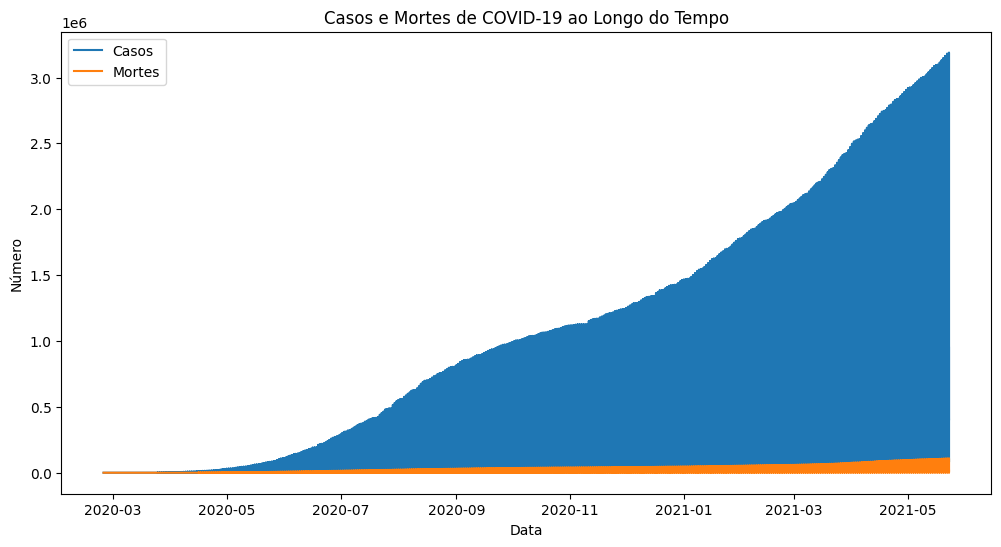

In [36]:
# Carregar o dataset
data = df.copy()
data['data'] = pd.to_datetime(data['date'])
data.set_index('data', inplace=True)

# Visualização inicial
plt.figure(figsize=(12, 6))
plt.plot(data['cases'], label='Casos')
plt.plot(data['deaths'], label='Mortes')
plt.xlabel('Data')
plt.ylabel('Número')
plt.title('Casos e Mortes de COVID-19 ao Longo do Tempo')
plt.legend()
plt.show()

Em uma análise conjunta, aparentemente, o crescimentod e casos foi quase exponencial em quanto o crescimento da quantidade de mortes foi quase linear. No entanto, não é correto afirmar isso devido às diferentes escalas.

                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     4757.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:49:30   Log-Likelihood:            -1.7107e+05
No. Observations:               12258   AIC:                         3.422e+05
Df Residuals:                   12256   BIC:                         3.422e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.135e+04   5023.226    -18.185      0.0

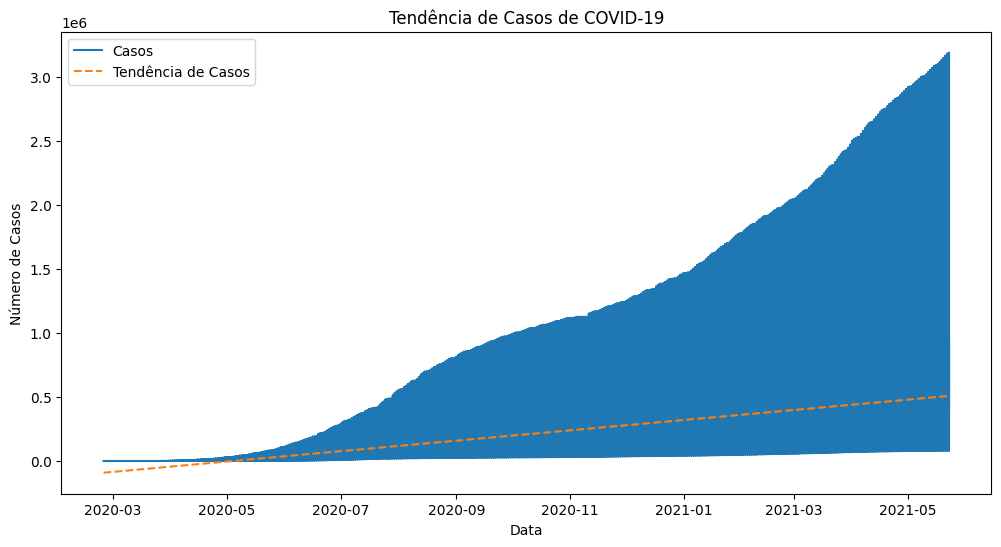

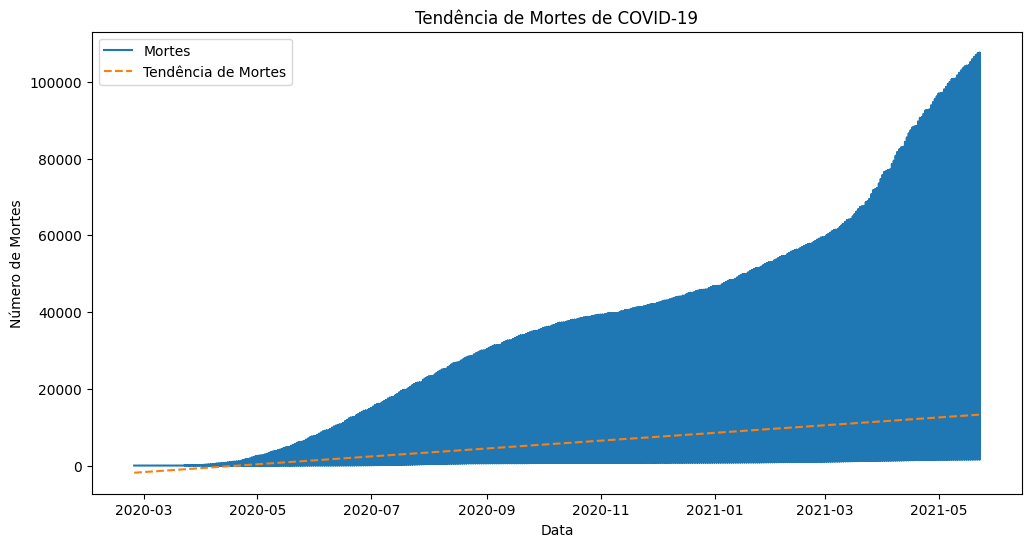

In [39]:
# Regressão linear para os casos
data['time_index'] = (data.index - data.index.min()).days  # Índice temporal (dias desde o início)

X_cases = sm.add_constant(data['time_index'])  # Adiciona uma constante para o intercepto
y_cases = data['cases']

model_cases = sm.OLS(y_cases, X_cases).fit()
print(model_cases.summary())

# Regressão linear para as mortes
y_deaths = data['deaths']

model_deaths = sm.OLS(y_deaths, X_cases).fit()
4

# Plotando a linha de tendência
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['cases'], label='Casos')
plt.plot(data.index, model_cases.predict(X_cases), label='Tendência de Casos', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.title('Tendência de Casos de COVID-19')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['deaths'], label='Mortes')
plt.plot(data.index, model_deaths.predict(X_cases), label='Tendência de Mortes', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Número de Mortes')
plt.title('Tendência de Mortes de COVID-19')
plt.legend()

**Significância Global do Modelo:**

**F-statistic**: 4757 e 2747 com valor-p de 0.00
Indica que o modelo é estatisticamente significativo, ou seja, pelo menos um dos coeficientes é diferente de zero.

## Conclusão para tendência temporal com uma Regressão Linear simples


Embora ambos os modelos indiquem que "time_index" é uma variável significativa, o primeiro modelo explica uma proporção maior da variabilidade da variável dependente em comparação com o segundo. Ambos os modelos apresentam problemas de normalidade dos resíduos, o que pode afetar a validade das inferências. A autocorrelação dos resíduos é uma preocupação maior no segundo modelo. Dependendo do contexto, pode ser necessário considerar modelos mais complexos ou incluir mais variáveis explicativas para melhorar a capacidade preditiva e a validade dos modelos.


## Sazonalidade
Para realizar a análise de sazonalidade nos casos e mortes de COVID-19, você utilizaremos técnicas de séries temporais

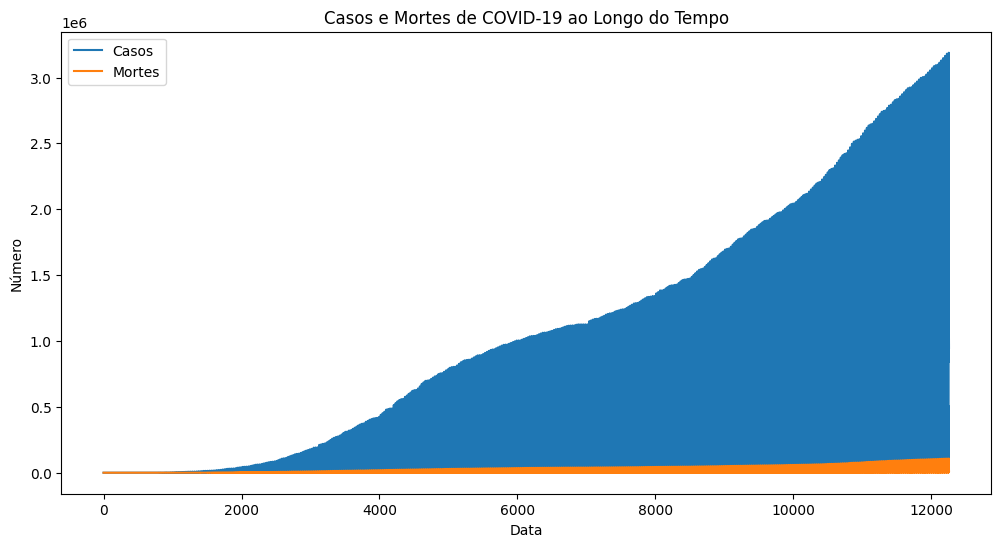

In [42]:
data = df.copy()
data['data'] = pd.to_datetime(data['date'])

# Plot inicial das séries temporais
plt.figure(figsize=(12, 6))
plt.plot(data['cases'], label='Casos')
plt.plot(data['deaths'], label='Mortes')
plt.xlabel('Data')
plt.ylabel('Número')
plt.title('Casos e Mortes de COVID-19 ao Longo do Tempo')
plt.legend()
plt.show()

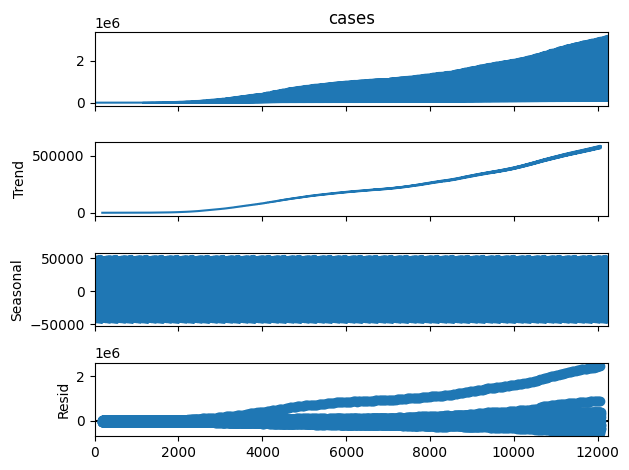

In [49]:
# Decomposição sazonal
resultados_casos = seasonal_decompose(data['cases'], model='additive', period=365)
resultados_mortes = seasonal_decompose(data['deaths'], model='additive', period=365)


# Plot da decomposição de casos
resultados_casos.plot()
plt.show()


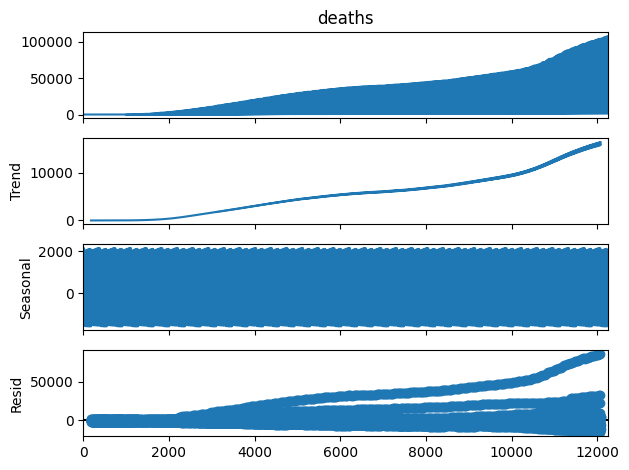

In [50]:
resultados_mortes.plot()
plt.show()

**Tendência Crescente:** A série temporal de mortes tem uma tendência de aumento ao longo do tempo.

**Padrão Sazonal:** Há um padrão sazonal claro, sugerindo que as mortes flutuam de forma regular e previsível ao longo do tempo.

**Resíduos Variáveis:** A variabilidade dos resíduos aumenta com o tempo, o que pode indicar problemas como heterocedasticidade. Isso sugere que a variância dos erros não é constante, o que pode afetar a validade de algumas inferências estatísticas e previsões.

Como foi identificado um padrão sazonal, será utilizado um modelo SARIMA para realização de previsões. Tendo em vista que SP houve um número muito grande casos e mortes, segue a previsão neste Estado.

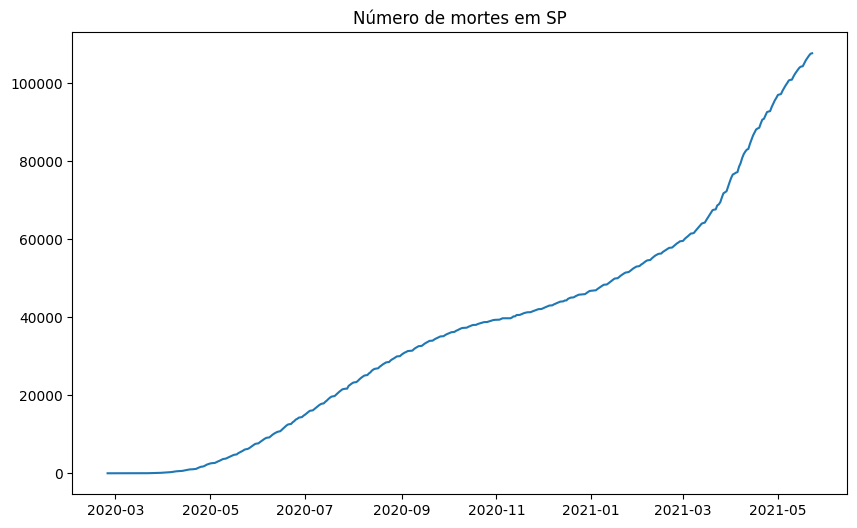

In [112]:
df['data'] = pd.to_datetime(df['date'])
df.set_index('data', inplace=True)

estado = 'SP'
serie = df[df['state'] == estado]['deaths']

plt.figure(figsize=(10,6))
plt.plot(serie)
plt.title(f'Número de mortes em {estado}')
plt.show()


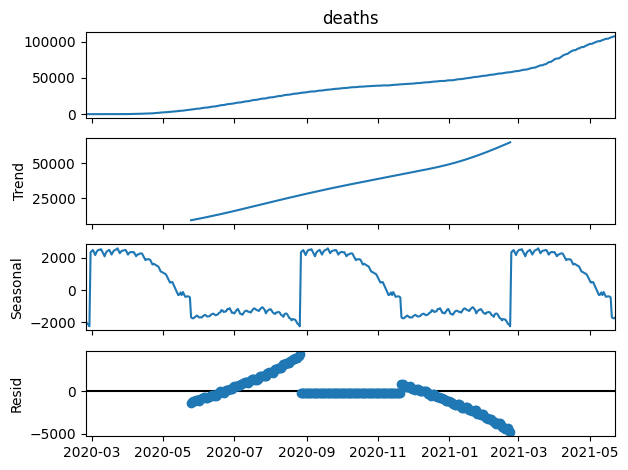

In [59]:
decomposicao = seasonal_decompose(serie, model='additive', period=180)
decomposicao.plot()
plt.show()

In [113]:
# Passo 4: Verificação da estacionariedade
result = adfuller(serie)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.6621836144009103
p-value: 0.9890521614702444


Com um p-value de 0.989, não podemos rejeitar a hipótese nula de que a série temporal tem uma raiz unitária. Isso significa que não temos evidências suficientes para concluir que a série é estacionária. Em outras palavras, com os dados fornecidos, concluímos que a série temporal é não estacionária.

In [120]:
model = auto_arima(serie, start_p=1, start_q=1,
                         test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          trace=False,
                          error_action='warn',
                          suppress_warnings=True,
                          stepwise=True)

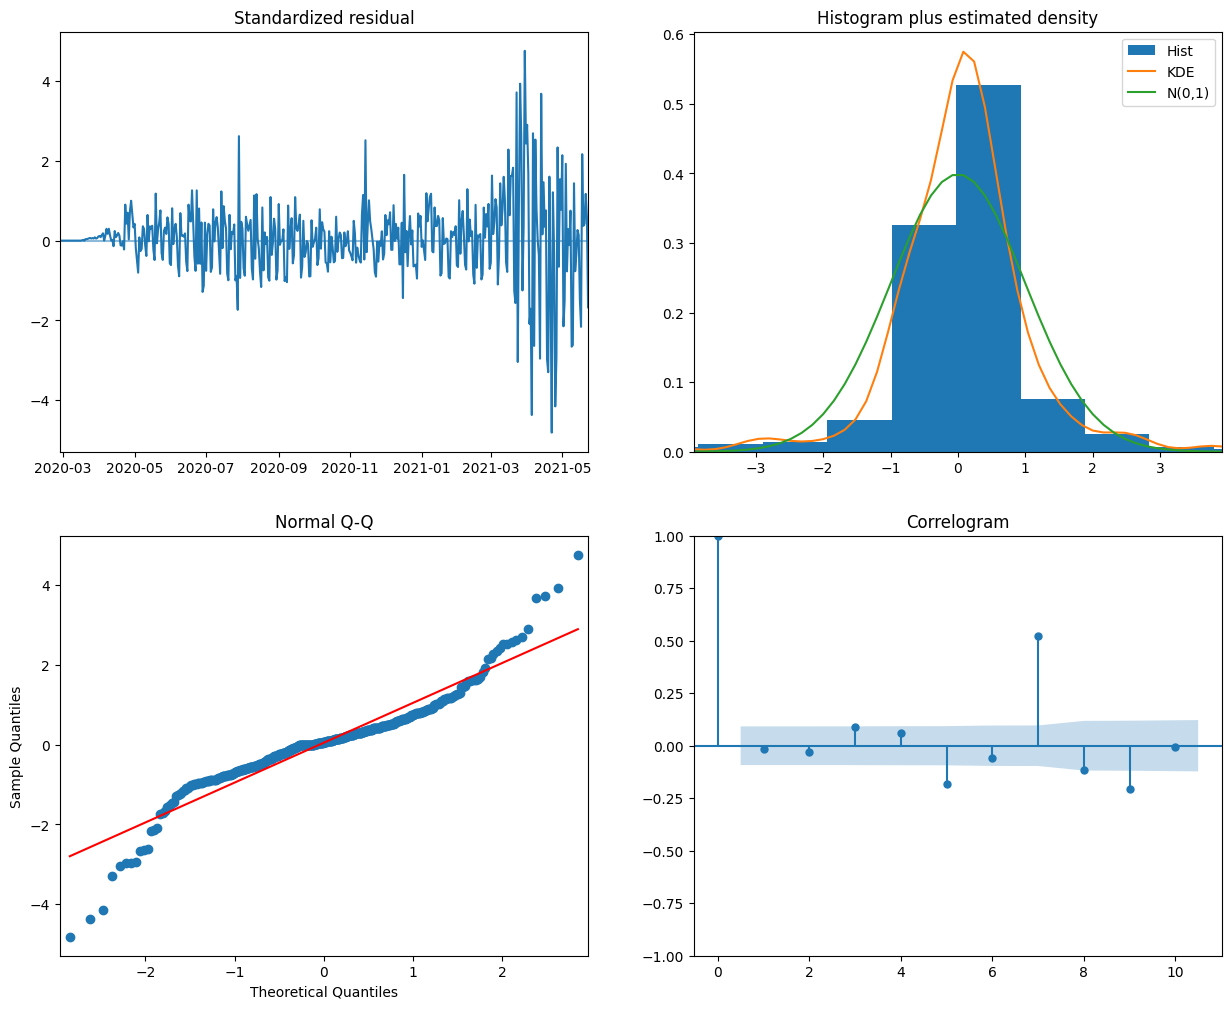

In [121]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [122]:
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  454
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -2926.682
Date:                Wed, 05 Jun 2024   AIC                           5863.365
Time:                        01:29:57   BIC                           5883.933
Sample:                    02-25-2020   HQIC                          5871.470
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9254      0.030     30.390      0.000       0.866       0.985
ar.L2         -0.4747      0.029    -16.492      0.000      -0.531      -0.418
ma.L1         -1.7471      0.031    -57.147      0.000      -1.807      -1.687
ma.L2          0.8249      0.029     28.313      0.000       0.768       0.882
sigma2      2.447e+04    897.928     27.252      0.000    2.27e+04    2.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               488.41
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              10.22   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

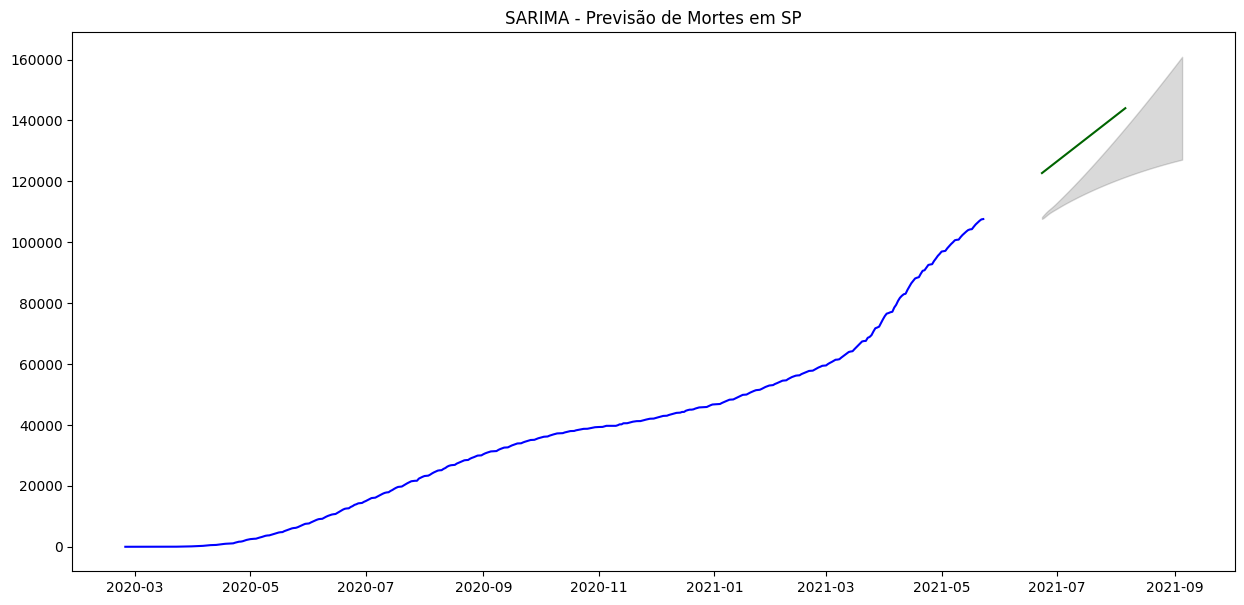

In [127]:
# Previsões

def forecast(model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(serie, color='blue')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMA - Previsão de Mortes em SP")
    plt.show()

forecast(model, periods=75)